In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model_name):
    model = model_from_json(open(model_name + 'model.json').read())
    model.load_weights(model_name + 'weights.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model_name, eps):
    p = np.sign(generate_grads(x, label, model_name))
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
eps = 0.3
max_n = 100

In [6]:
num_classes = 10

In [7]:
model_name = 'mnist_mlp_'

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_test  = X_test.reshape(10000, 784).astype('float32') / 255
print(X_test.shape[0], 'test samples')

y_test_catego = keras.utils.to_categorical(y_test, num_classes)
print(y_test_catego.shape)

10000 test samples
(10000, 10)


In [9]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps).reshape(784)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [10]:
adv_test = generate_adv_list(X_test[:max_n], y_test[:max_n], model_name, eps)
adv_test.shape

0




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




(100, 784)

In [11]:
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
score = model.evaluate(X_test, y_test_catego, verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

X_test
Test loss : 0.10931811571954518
Test accuracy : 0.9842


In [13]:
score = model.evaluate(X_test[:max_n], y_test_catego[:max_n], verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

X_test
Test loss : 4.2783838143805045e-05
Test accuracy : 1.0


In [14]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('adv_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv_test
Test loss : 15.227700386047363
Test accuracy : 0.0


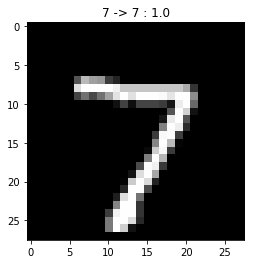

In [15]:
x = X_test[0]
y = y_test[0]

pred_class, pred_per = predict(x, model)
plt.imshow(x.reshape(28,28), 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

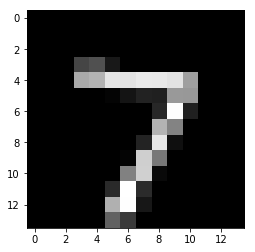

In [16]:
img = x.reshape(28,28)
small_img = cv2.resize(img,(14,14))

plt.imshow(small_img, 'gray')
plt.show()

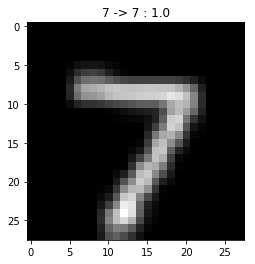

In [17]:
resized_img = cv2.resize(small_img,(28,28))

pred_class, pred_per = predict(resized_img, model)
plt.imshow(resized_img, 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

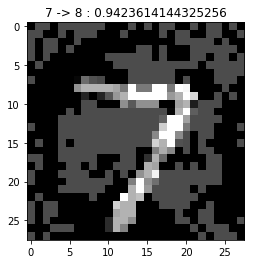

In [18]:
x = adv_test[0]
y = y_test[0]

pred_class, pred_per = predict(x, model)
plt.imshow(x.reshape(28,28), 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

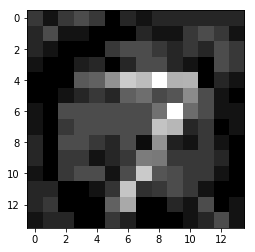

In [19]:
img = x.reshape(28,28)
small_img = cv2.resize(img,(14,14))

plt.imshow(small_img, 'gray')
plt.show()

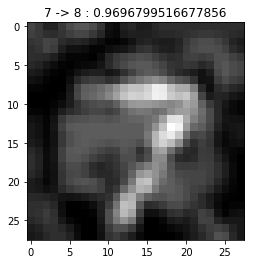

In [20]:
resized_img = cv2.resize(small_img,(28,28))

pred_class, pred_per = predict(resized_img, model)
plt.imshow(resized_img, 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

In [21]:
adv_reshaped = adv_test.reshape(-1, 28,28)
adv_small = np.array(list(map(lambda adv: cv2.resize(adv, (14,14)), adv_reshaped)))

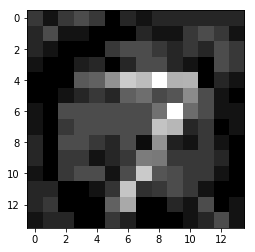

In [22]:
x = adv_small[0]

plt.imshow(x, 'gray')
plt.show()

In [23]:
adv_resized = np.array(list(map(lambda adv: cv2.resize(adv, (28,28)), adv_small)))

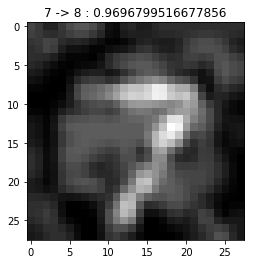

In [24]:
x = adv_resized[0]

pred_class, pred_per = predict(x.reshape(784), model)
plt.imshow(x, 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

In [25]:
adv_resized = adv_resized.reshape(-1, 784)

In [26]:
score = model.evaluate(adv_resized, y_test_catego[:max_n], verbose=0)
print('adv_resized')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv_resized
Test loss : 12.603579330444337
Test accuracy : 0.02


In [27]:
adv_reshaped = adv_test.reshape(-1, 28,28)
adv_small = np.array(list(map(lambda adv: cv2.resize(adv, (7,7)), adv_reshaped)))

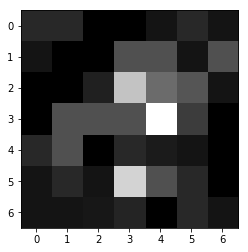

In [28]:
x = adv_small[0]

plt.imshow(x, 'gray')
plt.show()

In [29]:
adv_resized = np.array(list(map(lambda adv: cv2.resize(adv, (28,28)), adv_small)))

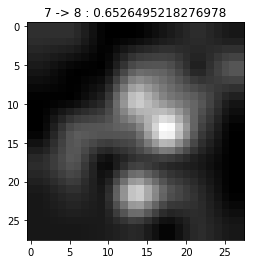

In [30]:
x = adv_resized[0]

pred_class, pred_per = predict(x.reshape(784), model)
plt.imshow(x, 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')
plt.show()

In [31]:
adv_resized = adv_resized.reshape(-1, 784)

In [32]:
score = model.evaluate(adv_resized, y_test_catego[:max_n], verbose=0)
print('adv_resized')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

adv_resized
Test loss : 13.448410415649414
Test accuracy : 0.01
